In [1]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import pickle
import halem
import datetime, time
import numpy as np
timeQ = time

"disable functions below if cartopy is unavailable"
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import halem
import flow_class
import os

from pandas import DataFrame

from IPython.display import clear_output
from scipy.spatial import Delaunay

from functions import *

In [2]:
# start_time = timeQ.time()

# flow = flow_class.flow_tidal_analysis()

# stop_time = timeQ.time()
# computation_time = stop_time - start_time
# print("the computational time is:", round(computation_time,2), "sec")

In [3]:
#  halem.save_object(flow, 'D:/Use_case_Schouwen/flow_route')

In [4]:
# plt.plot(flow.WD[:,20])

In [5]:
name_textfile_load = 'D:/Use_case_Schouwen/flow_route'

with open(name_textfile_load, 'rb') as input:
    flow = pickle.load(input)

In [6]:
x_r = np.arange(3.2,3.8, 0.0001)
y_r = np.arange(51,52, 0.001)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r2 = griddata((flow.nodes[:,1], flow.nodes[:,0]), flow.WD[0], (x_r, y_r), method= 'linear')

koppelpunt = [3.680414309976414,51.71550093282213]
winlocatie = [3.522637481591586,51.76880095558772]

In [7]:
flow.nodes.shape, flow.WD.shape

((34, 2), (361, 34))

In [8]:
class flow3():
    def __init__(self,flow):
        add_nodes = np.loadtxt('additional_nodes2.csv')[:,::-1]
        Zeros = np.zeros((len(flow.t), len(add_nodes)))
        
        nodes = np.concatenate((flow.nodes, add_nodes), axis = 0)
        WD = np.concatenate((flow.WD, Zeros), axis = 1)
        u = np.concatenate((flow.u,Zeros), axis = 1)
        v = np.concatenate((flow.v,Zeros), axis = 1)
        t = flow.t
        tria = Delaunay(nodes)
        self.u = u
        self.v = v
        self.WD = WD
        self.tria = tria
        self.t = t
        self.nodes = nodes 
        
QQ = flow3(flow)

# QQ.nodes

In [9]:
diff = flow.nodes*0 
diff[:,0] = 0.005
nodes = np.concatenate((flow.nodes, flow.nodes + diff, flow.nodes - diff), axis = 0)
WD = np.concatenate((flow.WD, flow.WD*0, flow.WD *0), axis = 1)
u = np.concatenate((flow.u, flow.u*0, flow.u *0), axis = 1)
v = np.concatenate((flow.v, flow.v*0, flow.v *0), axis = 1)
t = flow.t
tria = Delaunay(nodes)

In [17]:
flow2 = flow_class.flow3(flow)
halem.save_object(flow2, 'D:/Use_case_Schouwen/flow_route2')

In [16]:
load_factor =np.array([0, 0.4,0.5,0.6,0.7,0.8,0.9,1]) # Roadmap11

start = [3.67670012, 51.70969009]                     # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)
Volume = 20_000                                       # Total volume to be dregded                             (m^3)

ukc = 1.0                                             # Under Keel clearance                                   (m)
WWL = 20                                              # Width on Water Line                                    (m)
LWL = 80                                              # Length on Water Line                                   (m)
hopper_capacity = 1000                                # Maximal capacity of the hopper                         (m^3)
V_full = 10*0.514444444                               # Velocity in deep water when maximal loaded             (m/s)
V_emp = 12*0.514444444                                # Maximal sailing velocity empty in deep water           (m/s)
T_full = 6.6                                          # Draft when maximal Loaded                              (m)
T_emp = 4.5                                           # Draft When empty                                       (m)
WVPI_full = 10000                                     # Weight when maximal loaded                             (tf)
WVPI_empt = 4000                                      # Weight empty                                           (tf)

Q_cost = compute_cost(700_000, 0.008)                 # Cost function for route optimizer                      ($)
Q_co2 = compute_co2(1)                                # Cost function for route optimizer                      (g CO2)
Q_velo = compute_v_provider(V_emp, V_full)            # Vessel velocity is dependent on load factor
Q_loading = compute_loading(1.5)                      # Vessel loading time is dependent on load factor
Q_unloading = compute_unloading(1.5)                  # Vessel unloading time is dependent on load factor


service_hours = 168                                   # hours per week
delay_for_bunkering = 10                              # hours per week
technical_delay = 10                                  # hours per week
project_related_delay = 3                             # hours per week

load_factor

array([0. , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [12]:
nl = (0.5,1.5)
dx_min = 0.02
blend = 0.8
number_of_neighbor_layers = 1

vship =np.transpose([interpolate(load_factor, V_full, V_emp)])

WD_min= interpolate(load_factor, T_full, T_emp)
WVPI  = interpolate(load_factor, WVPI_full, WVPI_empt)

Load_flow = flow_class.flow_tides
name_textfile_flow = 'D:/Use_case_Schouwen/flow_route2'

start_time = time.time()

Roadmap   = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                        dx_min, 
                                        blend, 
                                        nl, 
                                        number_of_neighbor_layers, 
                                        vship, 
                                        Load_flow, 
                                        WD_min,
                                        WVPI,
                                        WWL = WWL,
                                        ukc = ukc,
                                        compute_cost = Q_cost,
                                        compute_co2 = Q_co2,
                                        repeat = True,
                                        nodes_index = np.arange(len(QQ.nodes)),
                                        optimization_type=['time']
                                       )

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

halem.save_object(Roadmap, 'Roadmap11SIM')

4/4
the computational time is: 2.43 sec


In [13]:
t0 = '17/04/2019 01:00:00'
start = [ 3.67025983, 51.70594537]
stop = [3.522637481591586,51.76880095558772]

vmax = 9
path_t, time_t, dist_t = halem.HALEM_time(start, stop, t0, vmax, Roadmap)


time_t

array([1.55545560e+09, 1.55545574e+09, 1.55545582e+09, 1.55545589e+09,
       1.55545596e+09, 1.55545602e+09, 1.55545608e+09, 1.55545614e+09,
       1.55545622e+09, 1.55545633e+09, 1.55545640e+09, 1.55545659e+09,
       1.55545679e+09, 1.55545695e+09, 1.55545727e+09, 1.55545759e+09,
       1.55545774e+09, 1.55545793e+09, 1.55545815e+09, 1.55545828e+09,
       1.55545847e+09, 1.55545862e+09, 1.55545878e+09, 1.55545894e+09,
       1.55545915e+09, 1.55545939e+09, 1.55545976e+09, 1.55545991e+09,
       1.55545999e+09])

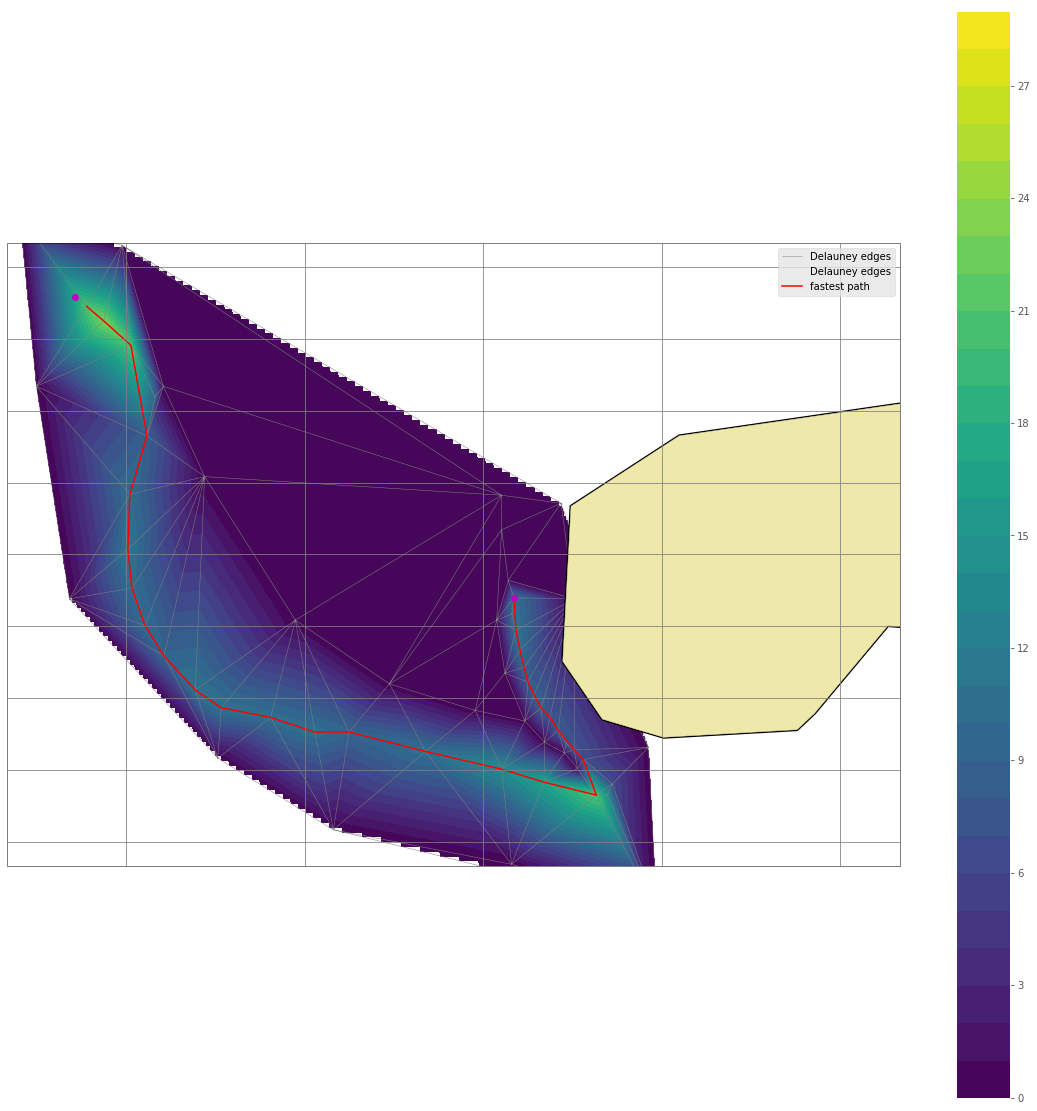

In [14]:
x_r = np.arange(3.2,3.8, 0.0001)
y_r = np.arange(51,52, 0.001)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r2 = griddata(Roadmap.nodes[:,::-1], Roadmap.WD[:,5], (x_r, y_r), method= 'linear')


fig = plt.figure(figsize = (20,20))
ax = plt.subplot(111)

ax = plt.subplot(1,1,1, projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))

cval = np.arange(0,30)
plt.contourf(x_r,y_r,WD_r2,cval, transform=ccrs.PlateCarree())
cbar = plt.colorbar()

plt.triplot(Roadmap.nodes[:,1], Roadmap.nodes[:,0], Roadmap.tria.simplices, linewidth = 0.5, transform=ccrs.PlateCarree(), color = 'grey', label = 'Delauney edges')

plt.plot(path_t[:,0], path_t[:,1],'r', markersize = 20, transform=ccrs.PlateCarree(), label = 'fastest path')


plt.plot(start[0], start[1],'mo',transform=ccrs.PlateCarree())
plt.plot(stop[0], stop[1], 'mo',transform=ccrs.PlateCarree() )

ax.set_extent([3.5,3.8,51.65,51.78])

plt.legend(loc='best')
plt.show()